In [2]:
import subprocess
import pandas as pd
from Bio import SeqIO
import numpy as np

MSA_files = ["Qa_MSA.fasta", "Qb_MSA.fasta", "Qc_MSA.fasta", "R_MSA.fasta"]
sequences_files = ["Qa.fasta", "Qb.fasta", "Qc.fasta", "R.fasta"]

In [3]:
def build_hmm(input_file, output_file):
    hmmbuild_command = f"hmmbuild {output_file} {input_file}"
    subprocess.call(hmmbuild_command, shell=True)
    

def score_sequence(sequence_file, hmm_file):
    evalues = {}
    sequences = {}
    
    result = subprocess.run(['hmmsearch', "--incE", "1000000", hmm_file, sequence_file], text=True, capture_output=True, check=True)
    output = result.stdout
    if "[No targets detected that satisfy reporting thresholds]" in output:
        return [], [], []
    lines = output.split("E-value")[3].split("Domain annotation for each sequence (and alignments):")[0].split("\n")
    
    lines = lines[2:-3]
    evalues = []
    scores = []
    sequences = []
    for line in lines:
        evalues.append(float(line.split()[0]))
        sequences.append(line.split()[-1])
        scores.append(float(line.split()[1]))
    return evalues, sequences, scores 

In [4]:
HMM_files = []
for index, file in enumerate(MSA_files):
    name = MSA_files[index].split(".")[0].split("_")[0] + ".hmm"
    HMM_files.append(name)
    build_hmm(MSA_files[index], name)



# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             Qa_MSA.fasta
# output HMM file:                  Qa.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     Qa_MSA                5033    54    54    25.58  1.028 

# CPU time: 0.06u 0.05s 00:00:00.11 Elapsed: 00:00:00.10
# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - -

In [10]:
def build_scoring_matrix(sequences_files, MSA_files, HMM_files):
    scoring_matrix = {}
    scoring_dfs = []
    all_labels = []

    for hmm_index, hmm_file in enumerate(HMM_files):
        scoring_matrix[hmm_file.split(".")[0]] = {}
        all_evalues = []
        all_scores = []
        row_names = []
        labels = []
        lengths = []
        for seq_index, seq_file in enumerate(sequences_files):
         
            evalues, seq_names, scores = score_sequence(seq_file, hmm_file)
            all_evalues.extend(evalues)
            row_names.extend(seq_names)
            all_scores.extend(scores)   
            ground_truth = [seq_file.split(".")[0]] * len(evalues)
            labels.extend(ground_truth)
            for single_seq in SeqIO.parse(seq_file, "fasta"):
                if single_seq.id in row_names:
                    lengths.append(len(single_seq.seq))     

        scoring_matrix[hmm_file.split(".")[0]]["Evalue"] = all_evalues
        scoring_matrix[hmm_file.split(".")[0]][ " score/length"] = np.array(all_scores)/np.array(lengths)
        scoring_matrix[hmm_file.split(".")[0]]["labels"] = labels
        scoring_matrix[hmm_file.split(".")[0]]["sequences"] = row_names
        
    for key, value in scoring_matrix.items():
        temp_df = pd.DataFrame(value).set_index('sequences')  # set 'names' as index
        temp_df.columns = [f'{col}{key}' for col in temp_df.columns]  # rename columns
        scoring_dfs.append(temp_df)
    scoring_data_frame = pd.concat(scoring_dfs, axis=1)

# replace None values with np.nan
    scoring_data_frame = scoring_data_frame.replace({None: np.nan})
 
    column_label_names = ["labels"+file.split(".")[0] for file in sequences_files]
    scoring_data_frame["labels"] = None
    scoring_data_frame["labels"] = scoring_data_frame[column_label_names].bfill(axis=1).iloc[:, 0]
    scoring_data_frame = scoring_data_frame.drop(column_label_names, axis=1)
    return scoring_data_frame

MSA_files = ["Qa_MSA.fasta", "Qb_MSA.fasta", "Qc_MSA.fasta", "R_MSA.fasta"]
sequences_files = ["Qa.fasta", "Qb.fasta", "Qc.fasta", "R.fasta"]
matrix = build_scoring_matrix(sequences_files, MSA_files, HMM_files)
matrix.to_csv('input_ML_Matrix.csv')

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
# Load your data
# matrix = pd.read_csv('input_ML_Matrix.csv')

# Separate features and target
X = matrix.drop('labels', axis=1)
y = matrix['labels']

# Values to replace np.nan with
replace_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100]

# Initialize cross-validation method
rkf = RepeatedKFold(n_splits=7, n_repeats=15)
v_scores = []
tr_scores = []
for value in replace_values:
    # Create a pipeline that first replaces np.nan values with the current value, then fits the random forest
    pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=value), RandomForestClassifier())
    
    # Perform cross-validation and get both training and test scores
    scores = cross_validate(pipeline, X, y, cv=rkf, return_train_score=True)
    
    # Print the mean training and test scores for this value
    print(f'Mean training accuracy for replacement value {value}: {scores["train_score"].mean()}')
    print(f'Mean test accuracy for replacement value {value}: {scores["test_score"].mean()}')
    v_scores.append(scores['test_score'].mean())
    tr_scores.append(scores['train_score'].mean())
    

Mean training accuracy for replacement value 0: 1.0
Mean test accuracy for replacement value 0: 0.9998582063098191
Mean training accuracy for replacement value 0.1: 1.0
Mean test accuracy for replacement value 0.1: 0.9998629327661585
Mean training accuracy for replacement value 0.2: 1.0
Mean test accuracy for replacement value 0.2: 0.9998345740281225


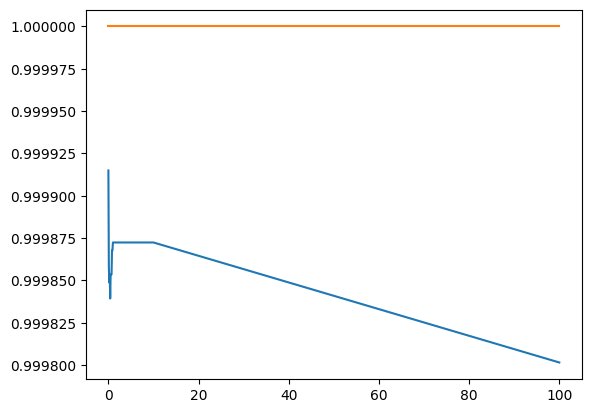

In [22]:
import matplotlib.pyplot as plt

plt.plot(replace_values, v_scores, label='Validation')
plt.plot(replace_values, tr_scores, label='Training')